# Modelling

Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import IPython
import os

import optuna

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import RFECV, SelectKBest, chi2, mutual_info_classif, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
import xgboost as xgb
from sklearn.svm import SVR
import statsmodels.api as sm

from functions import preprocessing, feature_engineer, drop_columns

Custom Functions and Classes

In [5]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """Class for pipeline to select only certain features"""

    def __init__(self, feature_names):
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return X[self.feature_names]

Data Import and Preprocessing

In [6]:
train_raw = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train_extended = pd.read_csv('data/train_extended.csv')

train = preprocessing(train_raw, train_extended)
train = train[(train.TeledyneRampWeight!=74283)]
# &(train.TeledyneRampWeight!=55726)

print(f'Number of rows dropped = {len(train_raw) - len(train)} ({round((len(train_raw) - len(train))*100/len(train_raw), 2)}%)')

train = feature_engineer(train)
test = feature_engineer(test)

extra_features_train = pd.read_csv('extra_data/distance_and_weight_train.csv')
extra_features_test = pd.read_csv('extra_data/distance_and_weight_test.csv')

train = train.merge(extra_features_train,on='FlightID')
test = test.merge(extra_features_test,on='FlightID')

vars_to_drop = [
    'FlightID','FlightNumber','AircraftRegistration','ScheduledRoute','DepartureScheduled','ArrivalScheduled',
    'AircraftTypeGroup'
    ]

train = drop_columns(train, vars_to_drop)
test = drop_columns(test, vars_to_drop)


train_dum = pd.get_dummies(train,columns=['AircraftCapacity','ServiceDescription', 'Carrier', 'AOCDescription'],drop_first=True)
test_dum = pd.get_dummies(test,columns=['AircraftCapacity','ServiceDescription', 'Carrier', 'AOCDescription'],drop_first=True)

# vars_to_drop2 = ['GreatCircleDistance','ServiceDescription_Charter Flight (Tour Operator)','Carrier_RR','Carrier_RK','Infants']

# train_dum = drop_columns(train_dum, vars_to_drop2)
# test_dum = drop_columns(test_dum, vars_to_drop2)

X = train_dum.drop('TeledyneRampWeight',axis=1)
y = train_dum['TeledyneRampWeight']
X_val = test_dum
X_val['Freight'] = [x if x < 10000 else 0 for x in X_val.Freight]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

sc = StandardScaler()
X_s = sc.fit_transform(X)
X_val_s = sc.transform(X_val)

sc = StandardScaler()
X_train_s = sc.fit_transform(X_train)
X_test_s = sc.transform(X_test)

Number of rows dropped = 5707 (0.75%)


Traditional R Approach

In [8]:
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     TeledyneRampWeight   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 2.899e+05
Date:                Sat, 15 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:16:14   Log-Likelihood:            -5.2478e+06
No. Observations:              607623   AIC:                         1.050e+07
Df Residuals:                  607600   BIC:                         1.050e+07
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

Distributions

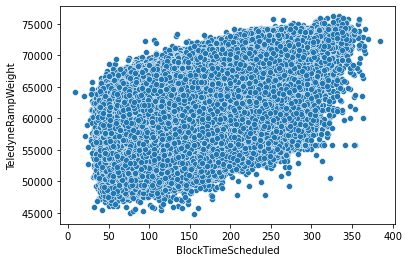

In [9]:
sns.scatterplot(data=train, x='BlockTimeScheduled', y='TeledyneRampWeight');

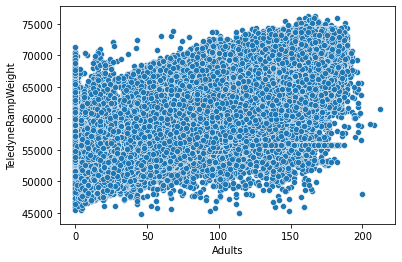

In [10]:
sns.scatterplot(data=train, x='Adults', y='TeledyneRampWeight');

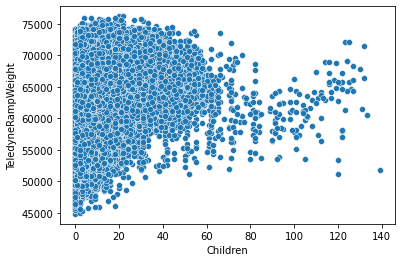

In [94]:
sns.scatterplot(data=train, x='Children', y='TeledyneRampWeight');

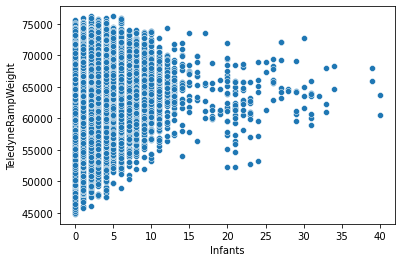

In [95]:
sns.scatterplot(data=train, x='Infants', y='TeledyneRampWeight');

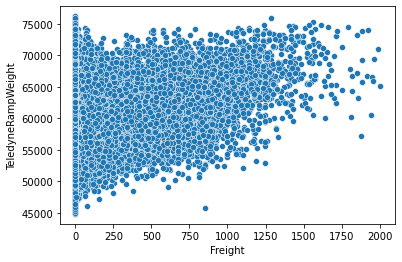

In [96]:
sns.scatterplot(data=train, x='Freight', y='TeledyneRampWeight');

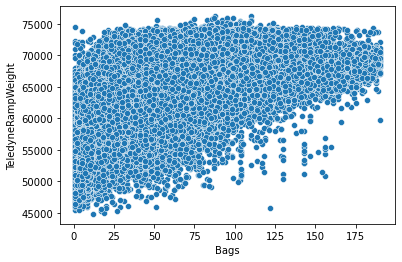

In [98]:
sns.scatterplot(data=train, x='Bags', y='TeledyneRampWeight');

### Feature Importance

In [46]:
# rfecv = RFECV(estimator=RandomForestRegressor(random_state=42))
# rfecv.fit(X_train_s, y_train)

# feature_importance = list(zip(X_train_s.columns, rfecv.support_))

# result_RFEcv = pd.DataFrame(list(zip(X_train_s.columns, rfecv.ranking_, rfecv.support_)), columns=['Features','Ranking','Support'])
# result_RFEcv.sort_values('Ranking')

In [ ]:
# rfecv_features = list(result_RFEcv[result_RFEcv['Support']==True]['Features'])

## Modelling

Linear Regression

In [10]:
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train_s)
X_test_pca = pca.transform(X_test_s)

lr = LinearRegression()
lr_pipe = lr
lr_pipe.fit(X_train_pca, y_train)

y_pred_train = lr_pipe.predict(X_train_pca)
y_pred = lr_pipe.predict(X_test_pca)

print('Train MAE:', mean_absolute_error(y_train, y_pred_train))
print('Test MAE:', mean_absolute_error(y_test, y_pred))

Train MAE: 958.6653289800496
Test MAE: 958.7002571951832


In [49]:
lr = LinearRegression()
lr_pipe = make_pipeline(PolynomialFeatures(degree=2, include_bias=False, interaction_only=True), lr)
lr_pipe.fit(X_train, y_train)

y_pred_train = lr_pipe.predict(X_train)
y_pred = lr_pipe.predict(X_test)

print('Train MAE:', mean_absolute_error(y_train, y_pred_train))
print('Test MAE:', mean_absolute_error(y_test, y_pred))

Train MAE: 883.6729328121777
Test MAE: 884.6253613225107


c:\Users\leofr\miniconda3\envs\datathon\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


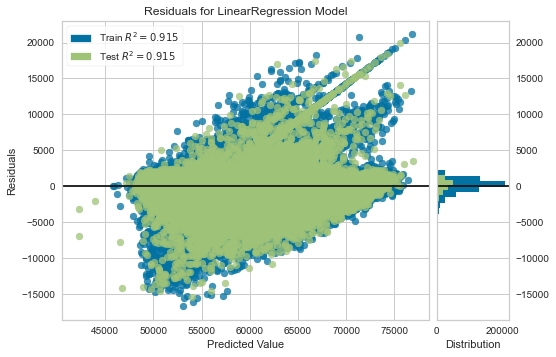

In [19]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lr_pipe, hist=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

In [59]:
lr = LinearRegression()
lr_pipe = make_pipeline(PolynomialFeatures(degree=2, include_bias=False, interaction_only=True), lr)
lr_pipe.fit(X, y)

y_pred = lr_pipe.predict(X_val)

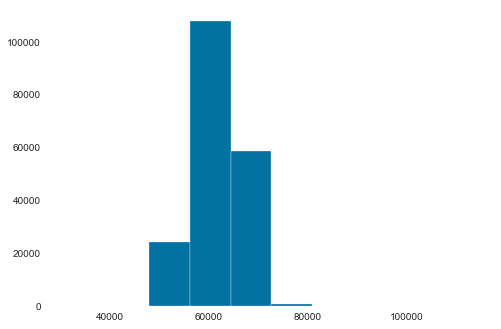

In [60]:
plt.hist(y_pred);

In [62]:
submission = pd.read_csv('data/sample_submission.csv').drop('TeledyneRampWeight',axis=1)
submission['TeledyneRampWeight'] = y_pred
submission.to_csv('lr_basic2.csv',index=False)

Elastic Nets

In [27]:
elastic_params = [0.001, 0.005, 0.01, 0.1, 1]
l1_ratio = np.arange(0.1, 1,0.1).astype(float)

elastic = make_pipeline(PolynomialFeatures(degree=2, include_bias=False, interaction_only=True), ElasticNetCV(alphas = elastic_params, l1_ratio=l1_ratio, cv = KFold(5), max_iter=2000))
elastic_fit = elastic.fit(X_train_s, y_train)
y_train_pred_elas1 = elastic_fit.predict(X_test_s)
y_pred_elas1 = elastic_fit.predict(y_test)

c:\Users\leofr\miniconda3\envs\datathon\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 436291120199.69183, tolerance: 1038716313.7625824
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\leofr\miniconda3\envs\datathon\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 419107169622.80896, tolerance: 1038716313.7625824
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\leofr\miniconda3\envs\datathon\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 440555006492.47815, tolerance: 1038716313.7625824
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\leofr\miniconda3\envs\datathon\lib

KeyboardInterrupt: 

In [64]:
elastic_nets = ElasticNet(alpha=0.001, l1_ratio=0.9)
elastic_nets.fit(X_s, y)
y_pred = elastic_nets.predict(X_val_s)

c:\Users\leofr\miniconda3\envs\datathon\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.061e+11, tolerance: 1.623e+09
  model = cd_fast.enet_coordinate_descent(


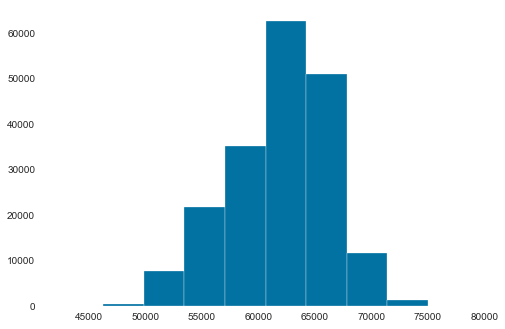

In [67]:
plt.hist(y_pred);

In [65]:
submission = pd.read_csv('data/sample_submission.csv').drop('TeledyneRampWeight',axis=1)
submission['TeledyneRampWeight'] = y_pred
submission.to_csv('elastic_nets.csv',index=False)

### Hyperparameter Tuning hehe

In [68]:
xg = xgb.XGBRegressor(random_state=42, use_label_encoder=False)
rf = RandomForestRegressor(random_state=42)
svm_l = SVR(kernel='linear') 
svm_rbf = SVR(kernel='rbf')
ab = AdaBoostRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

xg_params = {
    'clf__learning_rate':optuna.distributions.FloatDistribution(0.01,1),
    'clf__max_depth':optuna.distributions.IntDistribution(2,32),
    'clf__subsample':optuna.distributions.FloatDistribution(0,1),
    'clf__colsample_bytree':optuna.distributions.FloatDistribution(0,1),
    'clf__n_estimators':optuna.distributions.IntDistribution(64,256),
    'clf__gamma':optuna.distributions.FloatDistribution(0,1),
    'clf__reg_alpha':optuna.distributions.FloatDistribution(0,1),
    'clf__reg_lambda':optuna.distributions.FloatDistribution(0,1)
}

rf_params = {
    'clf__n_estimators':optuna.distributions.IntDistribution(64,256), 
    'clf__max_depth':optuna.distributions.IntDistribution(2,32),
    'clf__min_samples_split':optuna.distributions.FloatDistribution(0.1,1.0),
    'clf__min_samples_leaf':optuna.distributions.FloatDistribution(0.1,0.5),
    'clf__ccp_alpha':optuna.distributions.FloatDistribution(0,0.03)
}

svm_params = {
    'clf__gamma': optuna.distributions.FloatDistribution(0.0001,10),
    'clf__C': optuna.distributions.FloatDistribution(0.1,100)
}

dt_1 = DecisionTreeRegressor(max_depth=1, random_state=42)
dt_2 = DecisionTreeRegressor(max_depth=2, random_state=42)
dt_3 = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_4 = DecisionTreeRegressor(max_depth=4, random_state=42)
dt_5 = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_6 = DecisionTreeRegressor(max_depth=6, random_state=42)
dt_7 = DecisionTreeRegressor(max_depth=7, random_state=42)

ab_params = {
    'clf__base_estimator':optuna.distributions.CategoricalDistribution([dt_1,dt_2,dt_3,dt_4,dt_5,dt_6,dt_7]),
    'clf__n_estimators':optuna.distributions.IntDistribution(64,256),
    'clf__learning_rate':optuna.distributions.FloatDistribution(0.01,1)
}

gb_params = {
    'clf__learning_rate': optuna.distributions.FloatDistribution(0.01,1),
    'clf__n_estimators':optuna.distributions.IntDistribution(64,256),
    'clf__subsample':optuna.distributions.FloatDistribution(0,1),
    'clf__min_samples_split':optuna.distributions.FloatDistribution(0.1,1.0),
    'clf__min_samples_leaf':optuna.distributions.FloatDistribution(0.1,0.5),
    'clf__max_depth':optuna.distributions.IntDistribution(2,32),
}

all_models = [
    (xg,xg_params),
    ]

c:\Users\leofr\miniconda3\envs\datathon\lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains DecisionTreeRegressor(max_depth=1, random_state=42) which is of type DecisionTreeRegressor.
  warnings.warn(message)
c:\Users\leofr\miniconda3\envs\datathon\lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains DecisionTreeRegressor(max_depth=2, random_state=42) which is of type DecisionTreeRegressor.
  warnings.warn(message)
c:\Users\leofr\miniconda3\envs\datathon\lib\site-packages\optuna\distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains DecisionTreeRegressor(max_depth=3, random_state=42) which is of type DecisionTreeRegr

In [69]:
# Options
n_trials = 100
features_to_select = [list(X_train.columns)]

n = 0
best_run = 0
best_score = 0

for model, params in all_models:

    pipe = Pipeline([
        ('clf', model)
        ])

    tuner = optuna.integration.OptunaSearchCV(pipe, params, n_trials=n_trials, verbose=0, 
                                                    cv=KFold(5), scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
    tuner.fit(X_train_s, y_train)
    y_pred = tuner.predict(X_test_s)

    result = {}
    result['mae'] = mean_absolute_error(y_test, y_pred)
    result['features'] = list(X_train.columns)
    result['model'] = type(model).__name__
    best_params = tuner.best_params_
    if 'clf__base_estimator' in best_params.keys():
        best_params['clf__base_estimator'] = str(best_params['clf__base_estimator'])
    result['params'] = best_params
    
    with open(f'hypertuning_results/run_{n}.json','w') as fp:
        json.dump(result, fp)

    if result['mae'] > best_score:
        best_score = result['mae']
        best_run = n

    n += 1

    IPython.display.clear_output()
    print('----------------------------------------------------------------')
    print('Current Run:', n, '/', len(all_models) * len(features_to_select))
    print()
    print('Best Run:', best_run,'with MAE of:', best_score)
    print('----------------------------------------------------------------')

C:\Users\leofr\AppData\Local\Temp/ipykernel_8012/922340664.py:15: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  tuner = optuna.integration.OptunaSearchCV(pipe, params, n_trials=n_trials, verbose=0,
[I 2022-10-15 23:06:43,105] A new study created in memory with name: no-name-3aaa9498-5ac8-4103-9239-f0e83ecec2d9


In [5]:
json_files = [pos_json for pos_json in os.listdir('hypertuning_results/') if pos_json.endswith('.json')]

result_df = pd.DataFrame(columns=['Model','Features','MAE','Parameters','File'])

for index, js in enumerate(json_files):
    with open(os.path.join('hypertuning_results/', js)) as json_file:
        json_text = json.load(json_file)
        Model = json_text['model']
        Features = json_text['features']
        MAE = json_text['mae']
        Parameters = json_text['params'] 
        result_df.loc[index] = [Model, Features, MAE, Parameters, js]

result_df.sort_values(['MAE'], ascending=False).assign(N_features=lambda x: x.Features.str.len())[['Model','N_features','MAE','File']]

,Model,N_features,MAE,File
0,RandomForestRegressor,12,2578.585279,run_0.json


In [10]:
run_chosen = 'run_0.json'

best_features = list(result_df[result_df.File==run_chosen].Features)[0]
best_parameters = list(result_df[result_df.File==run_chosen].Parameters)[0]
best_model = rf

best_parameters

{'clf__n_estimators': 228,
 'clf__max_depth': 18,
 'clf__min_samples_split': 0.3076781562930755,
 'clf__min_samples_leaf': 0.21776136666071688,
 'clf__ccp_alpha': 0.0014875865972037105}

In [ ]:
{
    'clf__learning_rate': 0.6545098912916336, 'clf__max_depth': 5, 'clf__subsample': 0.6175784123319699, 
    'clf__colsample_bytree': 0.1649987195138093, 'clf__n_estimators': 76, 'clf__gamma': 0.8643942280394817, 
    'clf__reg_alpha': 0.5115966073654864, 'clf__reg_lambda': 0.8954056776145255
    }

In [11]:
xg = xgb.XGBRegressor(random_state=42, use_label_encoder=False)

best_parameters = {
    'clf__learning_rate': 0.21563304510763187, 'clf__max_depth': 5, 'clf__subsample': 0.4523796462139391, 
    'clf__colsample_bytree': 0.9415738523664323, 'clf__n_estimators': 199, 'clf__gamma': 0.3199645302133024, 
    'clf__reg_alpha': 0.12735409399547493, 'clf__reg_lambda': 0.5385090886972436
    }

best_pipe = Pipeline([
            ('clf', xg)
            ])

best_pipe.set_params(
    clf__learning_rate = best_parameters['clf__learning_rate'],
    clf__n_estimators = best_parameters['clf__n_estimators'],
    clf__max_depth = best_parameters['clf__max_depth'],
    clf__subsample = best_parameters['clf__subsample'],
    clf__colsample_bytree = best_parameters['clf__colsample_bytree'],
    clf__gamma = best_parameters['clf__gamma'],
    clf__reg_alpha = best_parameters['clf__reg_alpha'],
    clf__reg_lambda = best_parameters['clf__reg_lambda'],
);

In [12]:
best_pipe.fit(X_train_s, y_train)

y_pred_train = best_pipe.predict(X_train_s)
y_pred = best_pipe.predict(X_test_s)

print('Train MAE:', mean_absolute_error(y_train, y_pred_train))
print('Test MAE:', mean_absolute_error(y_test, y_pred))

Train MAE: 849.6232740570119
Test MAE: 858.9333320750168


(array([3.0000e+00, 1.0350e+03, 9.4080e+03, 1.9815e+04, 2.9795e+04,
        5.0751e+04, 5.3998e+04, 2.1709e+04, 4.5240e+03, 2.7100e+02]),
 array([44387.355, 47554.02 , 50720.684, 53887.348, 57054.01 , 60220.67 ,
        63387.336, 66554.   , 69720.664, 72887.33 , 76053.99 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

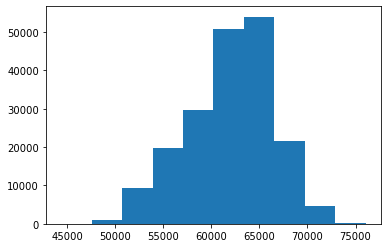

In [13]:
best_pipe.fit(X_s,y)
y_pred = best_pipe.predict(X_val_s)
plt.hist(y_pred)

In [14]:
submission = pd.read_csv('data/sample_submission.csv').drop('TeledyneRampWeight',axis=1)
submission['TeledyneRampWeight'] = y_pred
submission.to_csv('xg_boost_yay.csv',index=False)